# Hackathon Big Data

O primeiro desafio consiste em um cenário de previsão, onde o objetivo será prever o faturamento de cada uma das franquias de uma rede de lojas, onde as franquias estão espalhadas em todo o Brasil.

O segundo desafio consiste em um cenário de expansão, onde o objetivo será prever o faturamento que uma loja teria caso ela existisse em uma região que a franquia ainda não atua.

Este tipo de problema é muito importante para uma rede de franquias existente. A previsão do faturamento é importante para que a franquia possa ter uma estimativa da quantia que ela terá disponível para realizar investimentos e expansão das lojas. A previsão do faturamento em regiões que a loja não atua é importante para que a franquia possa realizar uma expansão mirando as regiões em que ela teria o maior faturamento possível.

# Desafio

**1. Prever o faturamento de lojas existentes na base de dados**

* Neste desafio as equipes deverão prever a média do faturamento mensal dos primeiros três meses de 2018 de cada loja presente na base de dados disponibilizada.

**2. Projetar o faturamento de novas lojas**

* Neste desafio as equipes deverão prever a média do faturamento mensal dos primeiros três meses de 2018 caso a loja existisse em uma região especificada.

O _notebook_ a seguir é estruturado da seguinte forma:

* 1. Coleta de dados
* 2. Descrição dos Dados
* 3. Feature Engineering
* 4. Análise de Dados Exploratória
* 5. Preparação dos dados
* 6. Seleção de _Features_
* 7. Modelagem de _Machine Learning_
* 8. Aprimoramento de _Hyperparameters_
* 9. Interpretação dos Resultados

# 1. COLETA DE DADOS

## 1.1. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle
import requests
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

## 1.2. Funções Auxiliares

In [49]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.rcParams['font.size'] = 25
    plt.rcParams["axes.labelsize"] = 25
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.display.float_format = '{:,.2f}'.format
    
    sns.set(font_scale = 1.3)
    sns.set_palette("dark")
    sns.set_context("notebook", font_scale = 1.3, rc={"font.size":25,"axes.titlesize":25,"axes.labelsize":25})
    
def calc_offset_date(df, ano, mes, min_ano = None, min_mes = None):
    '''
    Retorna o valor de offset_date
    '''
    
    if not min_ano:
        min_ano = df['ano'].min()
    
    if not min_mes:
        min_mes = df[df['ano'] == min_ano]['mes'].min()
        
    offset_date = (ano - min_ano) * (12) + mes - min_mes
    
    return offset_date

def get_offset_date(df):
    '''
    Coleta o vetor de offset_date
    '''   
        
    min_ano = df['ano'].min()
    min_mes = df[df['ano'] == min_ano]['mes'].min()
    
    offset_date_list = []
    
    for i in tqdm(range(len(df))):
        
        row = df.loc[i]
        offset_date = calc_offset_date(df, row['ano'], row['mes'], min_ano, min_mes)
        offset_date_list.append(offset_date)
        
    return offset_date_list

In [50]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.3. Carregando dados

São fornecidos 3 arquivos csv, sendo que o objetivo do problema é predizer a coluna "receita" para o dataset de teste.

* **Arquivos**

    * faturamento_lojas_atuais.csv: Faturamento mensal das lojas, contendo informações dos anos de 2016 e 2017

    * lojas_atuais.csv: Não iremos disponibilizar uma descrição das variáveis presentes neste arquivo. Elas representam as características das lojas, como a metragem, número de cadeiras, número de funcionários, etc. Este arquivo também contém  informações da localização da loja. As colunas de localização serão o código do município e código da área de ponderação. Estes códigos são os mesmos utilizados pelo IBGE

    * cenarios_exapansao.csv: Dados cadastrais de lojas para serem utilizadas no desafio 2. Este arquivo contém as mesmas informações contidas no arquivo lojas_atuais.csv
    
* **Features**

    * faturamento_lojas_atuais.csv:
        
        * cod_loja - número de identificação da loja, é único para cada loja
        
        * ano - ano de registro da receita
        
        * mes - mes de registro da receita
        
        * categoria (?) - categoria de produto vendido
        
        * qtde (?) - quantidade de produtos da categoria vendidos
        
        * receita - receita para a respectiva categoria de produtos no mês e ano especificados
        
    * lojas_atuais.csv e cenarios_expansao.csv:
        
        * cod_loja - número de identificação da loja, é único para cada loja
        
        * cod_ap - código de área de ponderação, definido pelo IBGE e restringem pequenas áreas dentro de municípios
        
        * cod_municipio - código do município, definido pelo IBGE
        
        * feature_01 a feature_18 - não explicitadas
        
Será elaborada a _dataframe_ **"df_raw"**, oriunda da junção de **"df_faturamento_raw"** e **"df_lojas_raw"**, carregados dos _datasets_ fornecidos. Por consequência, uma mesma loja possuirá várias linhas, representando o faturamento mês a mes.

In [4]:
df_expansao_raw = pd.read_csv("./data/raw/cenarios_expansao.csv")
df_faturamento_raw = pd.read_csv("./data/raw/faturamento_lojas_atuais.csv")
df_lojas_raw = pd.read_csv("./data/raw/lojas_atuais.csv")

# merge
df_raw = pd.merge(df_lojas_raw, df_faturamento_raw, how = 'left', on = 'cod_loja')
df_raw.head()

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,ano,mes,categoria,qtde,receita
0,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,1,CATEG_01,301.00,"9,164.86"
1,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,2,CATEG_01,187.00,"8,175.55"
2,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,3,CATEG_01,242.00,"10,521.67"
3,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,4,CATEG_01,104.00,"4,560.91"
4,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,5,CATEG_01,100.00,"4,263.30"


# 2. DESCRIÇÃO DOS DADOS

Esta seção incluirá os seguintes tópicos:

* Dimensão dos Dados

* Tipo dos Dados

* Verificação de Dados faltantes

* Estatística Descritiva

* Tratamento de Dados faltantes

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_01', 'feature_02',
       'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07',
       'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'ano', 'mes', 'categoria', 'qtde', 'receita'],
      dtype='object')

## 2.1. Dimensão dos Dados

De forma a entender quão grande o _dataset_ de análise é, será analisada a dimensão do _dataframe_ em questão. Verifica-se que há **1003094** linhas e **26** colunas.

In [7]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 1003094
Número de colunas: 26


## 2.2. Tipo dos Dados

Em seguida, serão analisados os tipos de dados existentes no _dataset_, de modo a abordar cada um apropriadamente.

In [8]:
df1.dtypes

cod_loja           int64
cod_ap             int64
cod_municipio      int64
feature_01        object
feature_02        object
feature_03          bool
feature_04       float64
feature_05        object
feature_06         int64
feature_07       float64
feature_08       float64
feature_09       float64
feature_10       float64
feature_11        object
feature_12        object
feature_13       float64
feature_14       float64
feature_15       float64
feature_16       float64
feature_17       float64
feature_18       float64
ano                int64
mes                int64
categoria         object
qtde             float64
receita          float64
dtype: object

## 2.3. Verificação dos Dados Faltantes

É necessário verificar dados faltantes pelo fato de os algoritmos de _Machine Learning_ atuais não reconhecerem dados nulos. Assim, para um melhor desempenho do modelo, é essencial avaliá-los. Observa-se que há muitos valores faltantes, que serão manipulados após uma análise estatística inicial.

In [9]:
# porcentagem de dados faltantes
df1.isna().sum().sort_values(ascending = False)/len(df1)

feature_11      0.92
feature_12      0.92
feature_15      0.71
feature_18      0.71
feature_17      0.71
feature_16      0.71
feature_14      0.71
feature_13      0.71
feature_01      0.63
feature_04      0.00
feature_03      0.00
feature_02      0.00
receita         0.00
feature_06      0.00
cod_municipio   0.00
cod_ap          0.00
feature_05      0.00
feature_10      0.00
feature_07      0.00
feature_08      0.00
feature_09      0.00
qtde            0.00
ano             0.00
mes             0.00
categoria       0.00
cod_loja        0.00
dtype: float64

## 2.4. Estatística Descritiva

Para realizar uma estatística descritiva, deve-se separar as variáveis númericas das categoricas, pois cada uma possuirá uma forma diferente de análise.

In [10]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']).drop(['cod_loja', 'cod_ap', 'cod_municipio', 'ano', 'mes'], axis = 1)
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 2.4.1. Variáveis Numéricas

Para as variáveis numéricas, serão realizadas dois tipos de análise:

* Tendência central
    * Média
    * Mediana
    
* Dispersão
    * Desvio Padrão
    * Mínimo
    * Máximo
    * Intervalo
    * Assimetria
    * Curtose

In [11]:
d1 = num_attributes.describe()
d2 = pd.DataFrame({"intervalo" : num_attributes.apply(lambda x: x.max() - x.min())}).T
d3 = pd.DataFrame({"assimetria" : num_attributes.apply(lambda x: x.skew())}).T
d4 = pd.DataFrame({"curtose" : num_attributes.apply(lambda x: x.kurtosis())}).T

m = pd.concat([d1, d2, d3, d4]).T.reset_index()
m

,index,count,mean,std,min,25%,50%,75%,max,intervalo,assimetria,curtose
0,feature_04,"1,003,094.00",34.39,13.78,3.50,25.66,31.92,41.11,117.36,113.86,1.05,2.60
1,feature_06,"1,003,094.00",5.75,4.95,0.00,3.00,4.00,7.00,63.00,63.00,3.80,24.55
2,feature_07,"1,003,094.00",0.17,0.05,0.06,0.14,0.18,0.20,0.41,0.35,0.50,0.97
3,feature_08,"1,003,094.00",0.17,0.05,0.04,0.13,0.17,0.19,0.39,0.35,0.33,0.70
4,feature_09,"1,003,094.00",602.74,"1,383.63",1.44,11.82,56.55,334.70,"5,593.91","5,592.47",2.95,7.56
5,feature_10,"1,003,094.00",3.92,2.64,0.42,2.40,3.16,4.46,31.80,31.38,3.29,19.35
6,feature_13,"289,056.00",94.82,8.58,44.10,92.20,100.00,100.00,100.00,55.90,-2.15,5.11
7,feature_14,"289,056.00",83.71,13.49,0.00,79.70,86.90,91.90,100.00,100.00,-3.27,16.43
8,feature_15,"289,056.00",82.51,34.54,0.00,100.00,100.00,100.00,100.00,100.00,-1.74,1.34
9,feature_16,"289,056.00",96.23,12.95,50.00,100.00,100.00,100.00,100.00,50.00,-3.23,8.55


In [12]:
# 'cod_loja', 'cod_ap', 'cod_municipio', 'ano', 'mes'
d5 = df1[['cod_loja', 'cod_ap', 'cod_municipio', 'ano', 'mes']]
d6 = pd.DataFrame({"max" : d5.apply(lambda x: x.max())}).T
d7 = pd.DataFrame({"min" : d5.apply(lambda x: x.min())}).T
d8 = pd.DataFrame({"count" : d5.apply(lambda x: x.size)}).T

m = pd.concat([d6, d7, d8]).T.reset_index()
m

,index,max,min,count
0,cod_loja,3687,1,1003094
1,cod_ap,5300108005050,-1,1003094
2,cod_municipio,5300108,-1,1003094
3,ano,2017,2016,1003094
4,mes,12,1,1003094


Observando os dados estatísticos de "receita", tem-se:

* Média = 9334,46; indica a média mensal de receita de todas lojas e todas categorias de produto
* Desvio Padrão (std) = 23670,26; este valor de desvio padrão diz que há valores negativos de receita, considerando a média acima, o que não faz sentido. Em análises bivariadas este parâmetro será mais explorado
* Mínimo (min) = 0; indica que, em determinado mês, alguma categoria de produto não vendeu nenhuma unidade 
* Máximo (max) = 975106,4
* Assimetria = 7,5; indica que os valores de receita possuem uma "cauda" mais longa do lado direito da ordenada, ou, em outras palavras, que os dados estão concentrados mais a esquerda quando comparados com uma distribuição normal
* Curtose = 94,52; indica o "achatamento" da curva, ou seja, a curva de receita é concentrada predominantemente em uma região

Além disso, verifica-se que há municípios com código "-1", o que deve ser considerado um dado faltante. Assim estes serão devidamente tratados mais adiante.

### 2.4.2. Atributos categóricos

Para a análise de atributos categóricos, são utilizados _boxplots_, de modo a analisar visualmente a dispersão, posição, simetria e outliers do _dataset_ em relação a receita.

É possível interpretar alguns resultados, como a CATEG_11, que é a categoria de produtos que possui uma maior receita quando comparado com os outros tipos de produto.

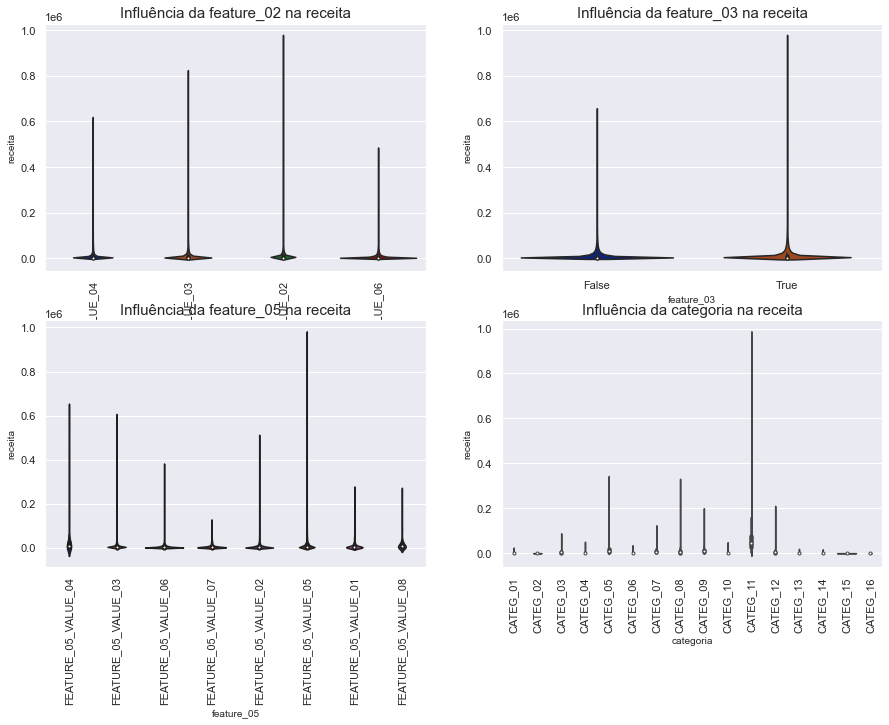

In [44]:
plt.subplot(2,2,1)
_ = sns.violinplot(x = 'feature_02', y = 'receita', data = df1)
_ = plt.xticks(rotation = 30)
_ = plt.title("Influência da feature_02 na receita")

plt.subplot(2,2,2)
_ = sns.violinplot(x = 'feature_03', y = 'receita', data = df1)
_ = plt.title("Influência da feature_03 na receita")

plt.subplot(2,2,3)
_ = sns.violinplot(x = 'feature_05', y = 'receita', data = df1)
_ = plt.xticks(rotation = 90)
_ = plt.title("Influência da feature_05 na receita")

plt.subplot(2,2,4)
_ = sns.violinplot(x = 'categoria', y = 'receita', data = df1)
_ = plt.xticks(rotation = 90)
_ = plt.title("Influência da categoria na receita")

# 3. FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 3.1. Tratamento de Dados faltantes

Pela alta porcentagem de dados faltantes observados na seção 2.3, seria arriscado preencher as lacunas com dados existentes, sendo tais colunas dropadas.

In [15]:
df2.drop(['feature_01', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18'], 
          inplace = True, axis = 1)

Já em relação aos códigos de município, os valores de "-1" serão substituidos por np.nan, para melhor visualizar os dados faltantes. Para preenchê-los, sera utilizado o np.random.choice, a partir de uma dada probabilidade de escolha de um código de área de ponderação em relação ao espaço amostral total.

In [16]:
df2.loc[df2['cod_municipio'] == -1, 'cod_municipio'] = np.nan
df2.loc[df2['cod_ap'] == -1, 'cod_ap'] = np.nan

df2[['cod_municipio', 'cod_ap']].isna().sum()

cod_municipio    47920
cod_ap           47920
dtype: int64

In [17]:
# cod_ap únicos
unique_ap = df2['cod_ap'].unique()

# criando vetor de probabilidades
p = []
for ap in unique_ap:
    prob = len(df2[df2['cod_ap'] == ap]) / df2['cod_ap'].notna().sum()
    p.append(prob)

# preenchendo valores
df2['cod_ap'].fillna(int(np.random.choice(unique_ap, 1, p = p)), inplace = True)

# checando se há valores não preenchidos:
print("Dados faltantes em cod_ap: {}".format(df2['cod_ap'].isna().sum()))

Dados faltantes em cod_ap: 0


Preenchidas as lacunas da variável "cod_ap", esta é transformada em formato "str" para ser manipulada. A partir da "cod_ap", é possível encontrar a "cod_municipio", cujo valor é representado pelos 7 primeiros caracteres de "cod_ap". Assim, tem-se:

In [18]:
# transformando cod_ap em object
df2['cod_ap'] = df2['cod_ap'].astype('int64').astype('str')

In [19]:
# adquirindo codigo de municipios
df2['cod_municipio'] = df2['cod_ap'].apply(lambda x: x[:7])

print("Dados faltantes em cod_municipio: {}".format(df2['cod_municipio'].isna().sum()))

Dados faltantes em cod_municipio: 0


## 3.2. Feature Engineering

Pelo fato de as _features_ não temporais não serem explicitadas claramente, o processo de _feature engineering_ será baseado unicamente nas variáveis temporais. Criam-se as seguintes varíaveis:

* estado - estado em que se encontra a loja, retirado a partir dos códigos de ponderação e de município
    * latitude - latitude média do estado em questão
    * longitude - longitude média do estado em questão

O código do estado é representado pelos 2 primeiros números de cada código de município. Assim, a partir da tabela a seguir, retirada do próprio IBGE, é possível identificar e classificar o estado de cada região:

**Região Norte**

| Código IBGE |   Estado  | Sigla |
|:-----------:|:---------:|:-----:|
|      11     |  Rondônia |   RO  |
|      12     |    Acre   |   AC  |
|      13     |  Amazonas |   AM  |
|      14     |  Roraima  |   RR  |
|      15     |    Pará   |   PA  |
|      16     |   Amapá   |   AP  |
|      17     | Tocantins |   TO  |

**Região Nordeste**

| Código IBGE |        Estado       | Sigla |
|:-----------:|:-------------------:|:-----:|
|      21     |       Maranhão      |   MA  |
|      22     |        Piauí        |   PI  |
|      23     |        Ceará        |   CE  |
|      24     | Rio Grande do Norte |   RN  |
|      25     |       Paraíba       |   PB  |
|      26     |      Pernambuco     |   PE  |
|      27     |       Alagoas       |   AL  |
|      28     |       Sergipe       |   SE  |
|      29     |        Bahia        |   BA  |

**Região Sudeste**

| Código IBGE |     Estado     | Sigla |
|:-----------:|:--------------:|:-----:|
|      31     |  Minas Gerais  |   MG  |
|      32     | Espírito Santo |   ES  |
|      33     | Rio de Janeiro |   RJ  |
|      35     |    São Paulo   |   SP  |

**Região Sul**

| Código IBGE |       Estado      | Sigla |
|:-----------:|:-----------------:|:-----:|
|      41     |       Paraná      |   PR  |
|      42     |   Santa Catarina  |   SC  |
|      43     | Rio Grande do Sul |   RS  |

**Região Centro-Oeste**

| Código IBGE |       Estado       | Sigla |
|:-----------:|:------------------:|:-----:|
|      50     | Mato Grosso do Sul |   MS  |
|      51     |     Mato Grosso    |   MT  |
|      52     |        Goiás       |   GO  |
|      53     |  Distrito Federal  |   DF  |

In [20]:
# verificando estados únicos
cod_estado = df2['cod_municipio'].str[:2]
cod_estado.unique()

array(['41', '53', '35', '31', '16', '11', '27', '29', '26', '25', '33',
       '32', '14', '43', '22', '23', '52', '51', '50', '17', '42', '13',
       '28', '15', '24', '12', '21'], dtype=object)

In [21]:
# offset_date
df2['offset_date'] = get_offset_date(df2)

# estado
cod_estado = df2['cod_municipio'].astype('str').str[:2]
cod_estado = cod_estado.replace({'11' : 'RO', '12' : 'AC', '13' : 'AM', '14' : 'RR', '15' : 'PA',
                                 '16' : 'AP', '17' : 'TO', '21' : 'MA', '22' : 'PI', '23' : 'CE',
                                 '24' : 'RN', '25' : 'PB', '26' : 'PE', '27' : 'AL', '28' : 'SE',
                                 '29' : 'BA', '31' : 'MG', '32' : 'ES', '33' : 'RJ', '35' : 'SP',
                                 '41' : 'PR', '42' : 'SC', '43' : 'RS', '50' : 'MS', '51' : 'MT',
                                 '52' : 'GO', '53' : 'DF'})
df2['estado'] =  cod_estado

# latitude e longitude
dict_estados_lat_long = {'AC': [ -8.77, -70.55], 'AL': [ -9.71, -35.73], 'AM': [ -3.07, -61.66], 'AP': [  1.41, -51.77]
, 'BA': [-12.96, -38.51], 'CE': [ -3.71, -38.54], 'DF': [-15.83, -47.86], 'ES': [-19.19, -40.34], 'GO': [-16.64, -49.31]
, 'MA': [ -2.55, -44.30], 'MT': [-12.64, -55.42], 'MS': [-20.51, -54.54], 'MG': [-18.10, -44.38], 'PA': [ -5.53, -52.29]
, 'PB': [ -7.06, -35.55], 'PR': [-24.89, -51.55], 'PE': [ -8.28, -35.07], 'PI': [ -8.28, -43.68], 'RJ': [-22.84, -43.15]
, 'RN': [ -5.22, -36.52], 'RO': [-11.22, -62.80], 'RS': [-30.01, -51.22], 'RR': [  1.89, -61.22], 'SC': [-27.33, -49.44]
, 'SE': [-10.90, -37.07], 'SP': [-23.55, -46.64], 'TO': [-10.25, -48.25]}

# Latitude e longitude
df2['lat'] = df2[df2['estado'] != 'na']['estado'].apply(lambda row: dict_estados_lat_long[row][0])
df2['long'] = df2[df2['estado'] != 'na']['estado'].apply(lambda row: dict_estados_lat_long[row][1])

df2.head()

100%|██████████████████████████████████████████████████████████████████████| 1003094/1003094 [07:50<00:00, 2132.61it/s]


,cod_loja,cod_ap,cod_municipio,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,ano,mes,categoria,qtde,receita,offset_date,estado,lat,long
0,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,1,CATEG_01,301.00,"9,164.86",0,PR,-24.89,-51.55
1,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,2,CATEG_01,187.00,"8,175.55",1,PR,-24.89,-51.55
2,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,3,CATEG_01,242.00,"10,521.67",2,PR,-24.89,-51.55
3,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,4,CATEG_01,104.00,"4,560.91",3,PR,-24.89,-51.55
4,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,5,CATEG_01,100.00,"4,263.30",4,PR,-24.89,-51.55


# 4. ANÁLISE DE DADOS EXPLORATÓRIA

O processo de Análise de Dados Exploratória consiste em visualizar e analisar os dados e extrair _insights_ deles. Esta parte será realizada em três etapas principais:

* Análise Univariada
* Análise Bivariada
* Análise Multivariada

In [23]:
df3 = df2.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável de interesse

É elaborado um gráfico temporal ao longo dos meses, para cada ano, para analisar a variável de receita total, considerando todas categorias de produtos. É possível verificar que a receita possui certos picos, mais especificamente perto dos meses 5 e 8 (maio e agosto) e um pico global no fim do ano (mês 12), sendo que o comportamento similar indica a pequena relevância da feature "ano" no valor da receita final, sendo que possivelmente será dropada mais adiante. Tais picos de receita podem ser efeitos de datas comemorativas, como dia das mães e natal. Ademais, é possível observar um comportamento semelhante entre as receitas dos anos de 2016 e 2017.

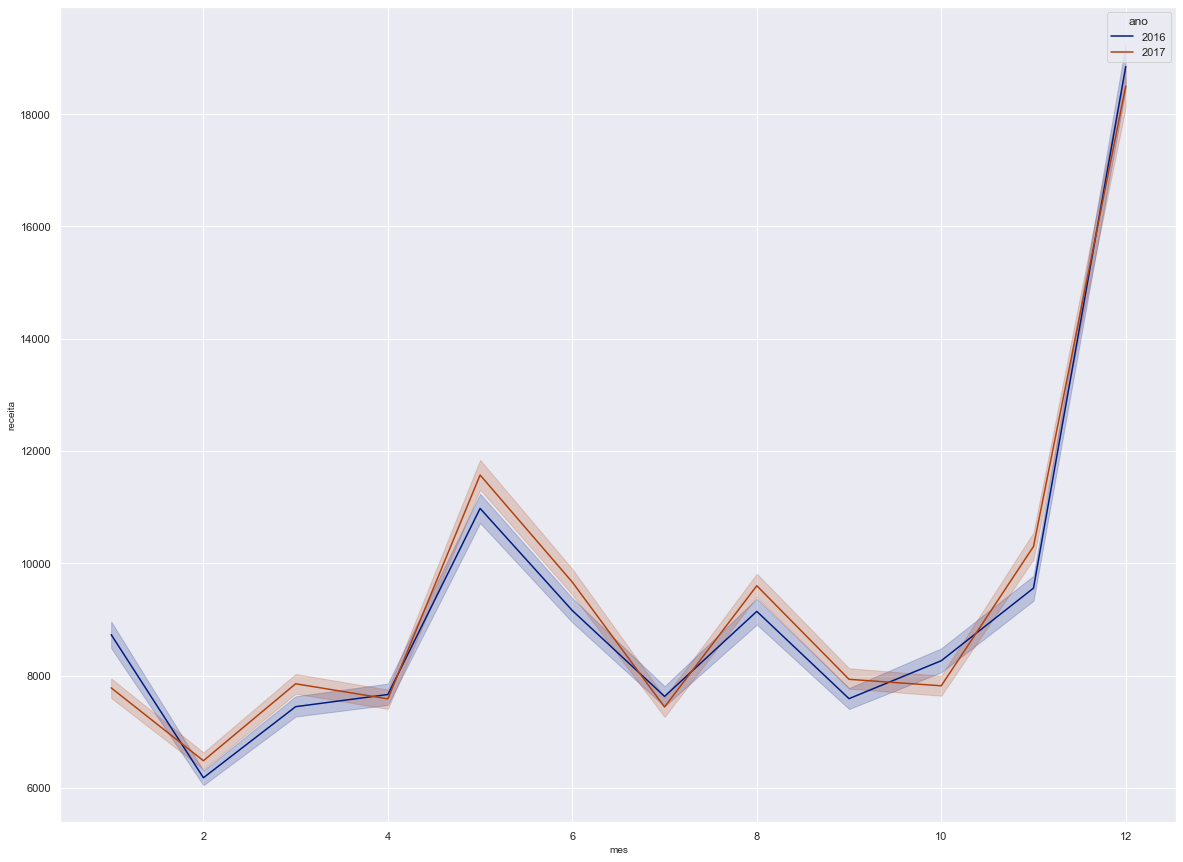

In [24]:
_ = sns.lineplot(data = df3, x = 'mes', y = 'receita', hue = 'ano', palette = 'dark')

### 4.1.2. Variáveis numéricas

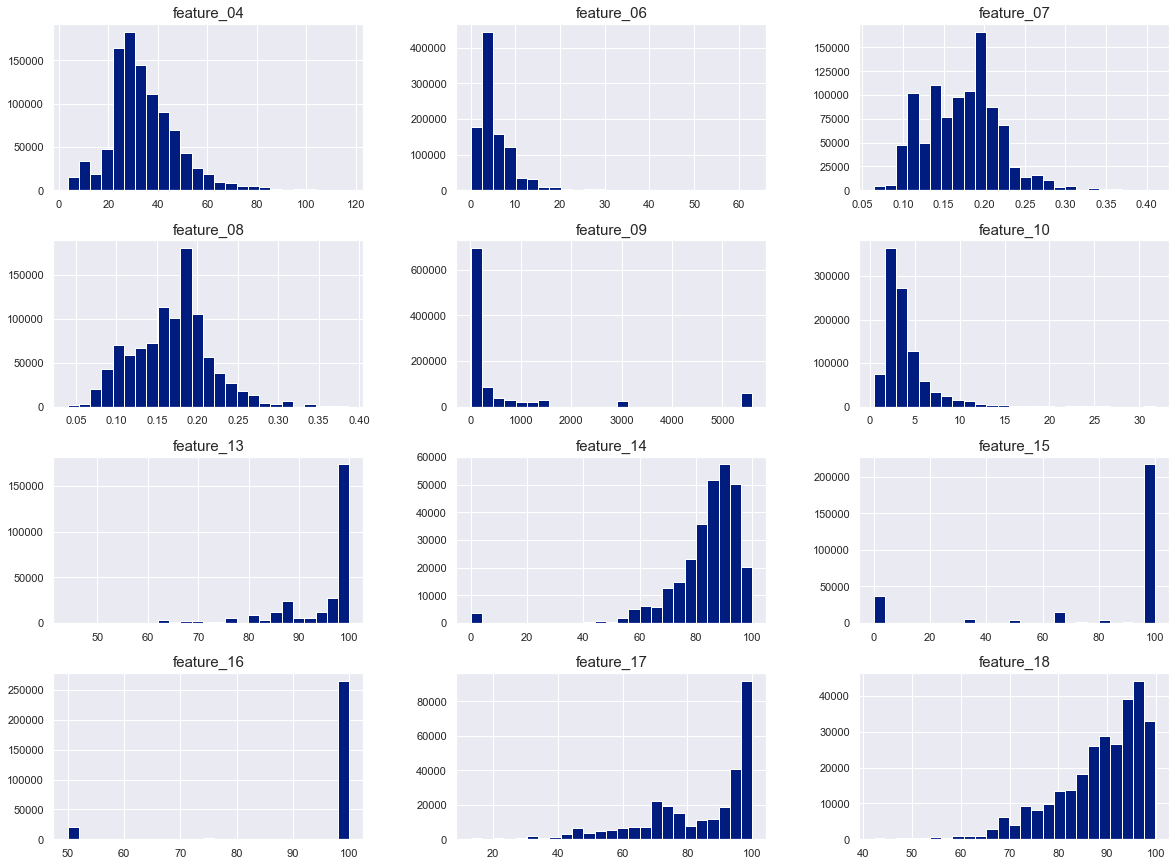

In [25]:
_ = num_attributes.drop(['receita', 'qtde'], axis = 1).hist(bins = 25)

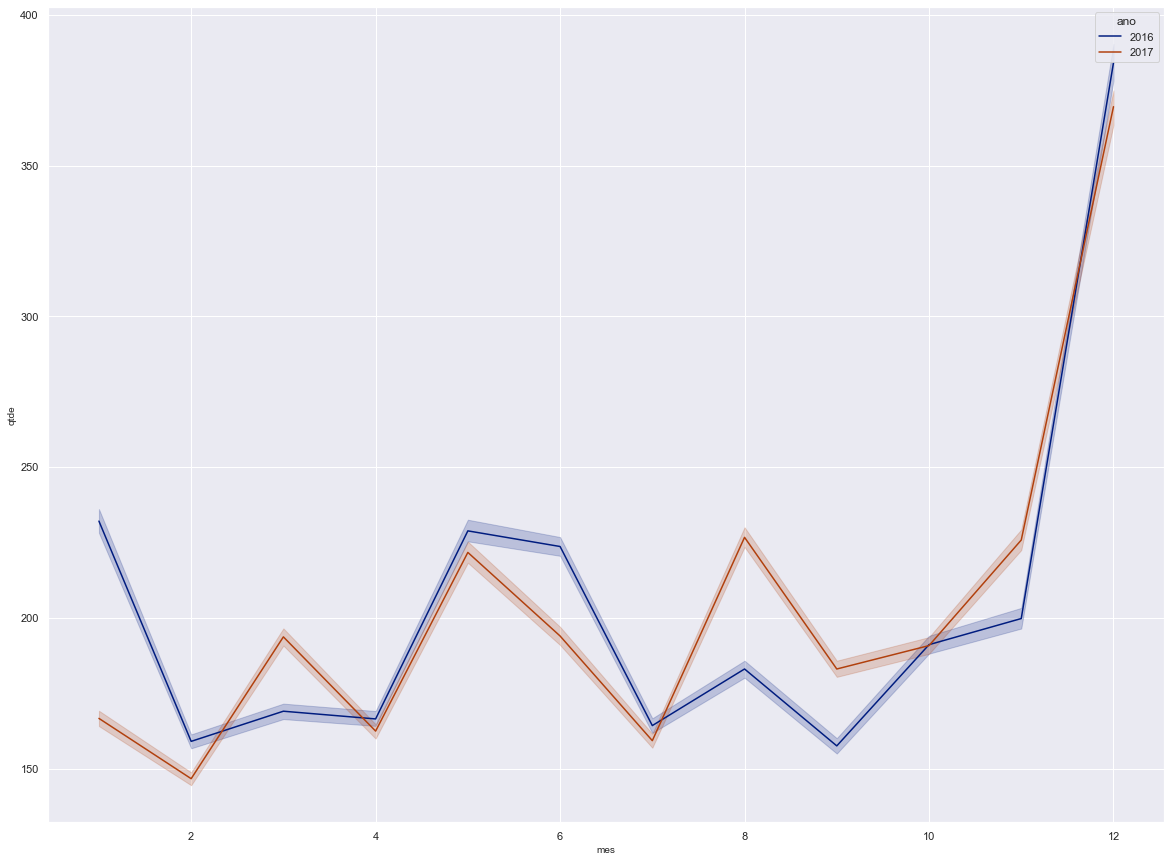

In [26]:
_ = sns.lineplot(data = df3, x = 'mes', y = 'qtde', hue = 'ano', palette = 'dark')

Dos gráficos acima é possível inferir algumas coisas:

* **feature_04, feature_07, feature_08** : possuem distribuição normal com assimetria positiva, ou seja, a média está mais a esquerda em relação a um distribuição normal

* **feature_06, feature_09, feature_10** : também possuem distribuições assimétricas, só que mais acentuadas, sendo que a maior parte dos dados se concentram abaixo da média

* **qtde** : gerado da mesma maneira que a receita, o gráfico de qtde demonstra, de forma geral, os mesmos picos do gráfico de receita. Observa-se que o comportamento das curvas entre anos se mostra mais distinto em valores absolutos

In [27]:
df3.select_dtypes(include = 'object').columns

Index(['cod_ap', 'cod_municipio', 'feature_02', 'feature_05', 'categoria',
       'estado'],
      dtype='object')

<AxesSubplot:xlabel='estado', ylabel='count'>

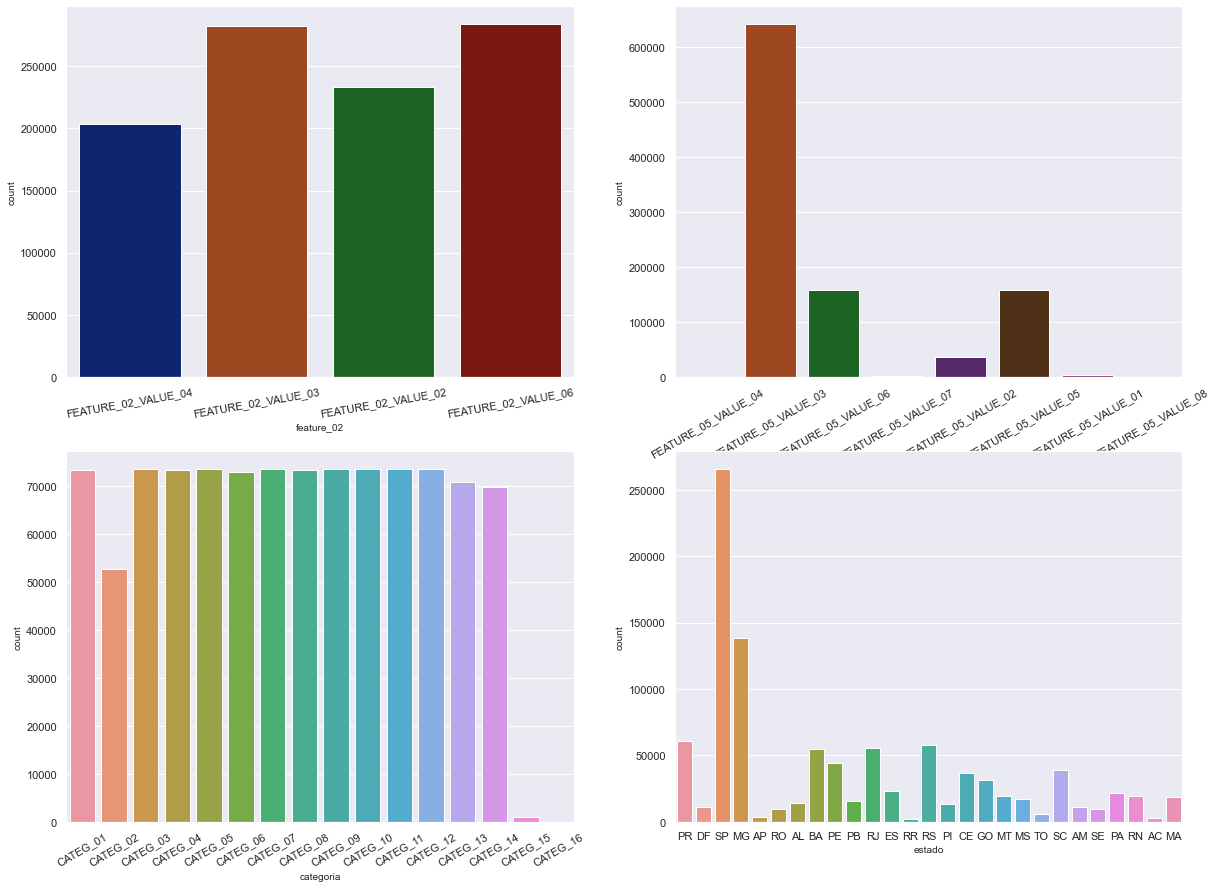

In [28]:
# feature_02
plt.subplot(2,2,1)
_ = sns.countplot(df3['feature_02'])
_ = plt.xticks(rotation = 10)

# feature_05
plt.subplot(2,2,2)
_ = sns.countplot(df3['feature_05'])
_ = plt.xticks(rotation = 30)

# categoria
plt.subplot(2,2,3)
_ = sns.countplot(df3['categoria'])
_ = plt.xticks(rotation = 30)

# estado
plt.subplot(2,2,4)
_ = sns.countplot(df3['estado'])

É possivel inferir algumas informações destes gráficos:

* feature_02: dados são balanceados entre classes, um bom sinal
* feature_05: dados desbalanceados, deve-se tomar cuidado, pode trazer resultados enviesados
* categoria: observa-se quantidade mínima de produtos vendidos das categorias 15 e 16, importante observar o que ocorreu
* estado: verifica-se que, predominantemente, estados da região sudeste vendem mais produtos, com SP e MG no top 2 e RJ e SC com números expressivos

## 4.2. Análise Bivariada

### 4.2.1. Hipóteses

**H1. ANO**

* O padrão de receita se repete ao longo dos anos

**H2. MÊS**

* A receita cresce em meses com datas festivas pertinentes

**H3. ESTADO**

* Região Sudeste concentra a maior parte das vendas das lojas

**H4. CATEGORIA**

* Diferentes categorias de produto tendem a possuir receitas distintas

**H5. QUANTIDADE**

* Quanto mais produtos são vendidos, maior a receita

### H1. O padrão de receita se repete ao longo dos anos

**Verdadeiro**. Comparando os gráficos de receita dos anos de 2016 e 2017 ao longo dos meses, verifica-se um comportamento similar dos valores, o que é confirmado pela pequena correlação de Pearson, indicando uma relação quase nula da _feature_ "ano" com a receita. Assim, há grandes evidências que a _feature_ pode ser dropada.

<AxesSubplot:>

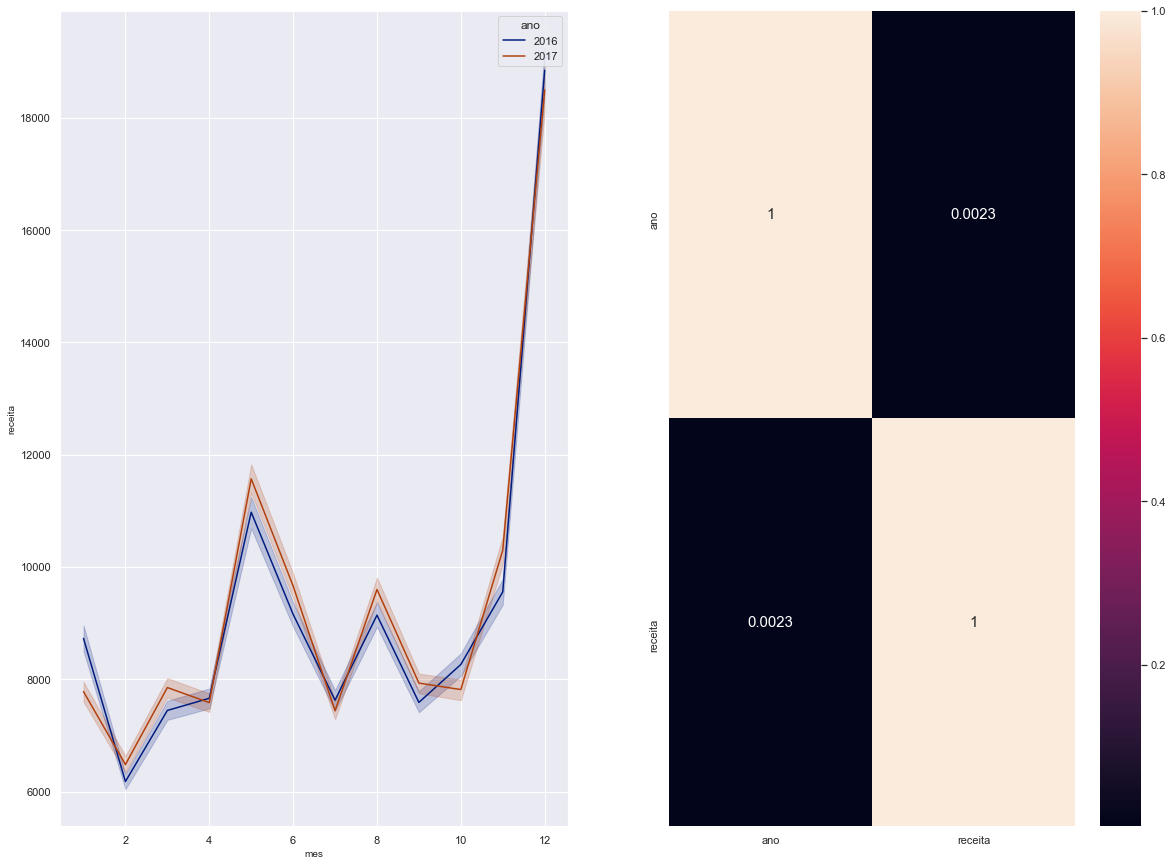

In [32]:
# plot 1
plt.subplot(1,2,1)
_ = sns.lineplot(data = df3, x = 'mes', y = 'receita', hue = 'ano', palette = 'dark')
_ = plt.title("Receita ao longo dos meses", fontsize = 25)

# plot 2
plt.subplot(1,2,2)
_ = sns.heatmap(df3[['ano', 'receita']].corr(method = 'pearson'), annot = True)
_ = plt.title("Correlação de Pearson", fontsize = 25)

### H2. A receita cresce em meses com datas festivas pertinentes

**Verdadeiro**. A partir do mesmo gráfico gerado na H1, verifica-se que há picos de venda nos meses 5, 8 e 12 (maio, agosto, dezembro), que concentram algumas datas festivas pertinentes, como dia das mães, dia dos pais e natal, respectivamente.

### H3. Região Sudeste concentra a maior parte das vendas das lojas

**Verdadeiro**. Verifica-se que os estados com maior receita são SP e MG, além de RJ e SC possuirem valores expressivos.

Text(0.5, 1.0, 'Receitas para cada estado')

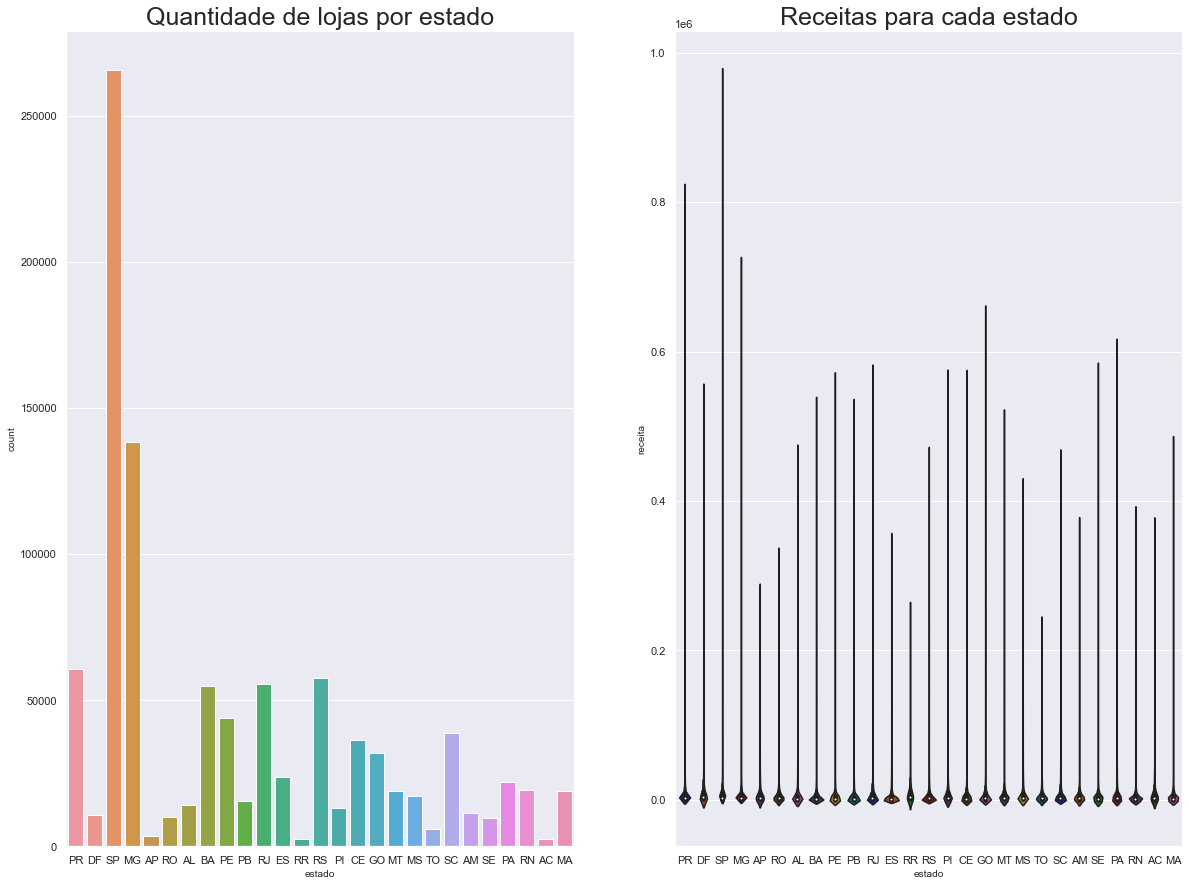

In [36]:
# plot 1
plt.subplot(1,2,1)
_ = sns.countplot(df3['estado'])
_ = plt.title("Quantidade de lojas por estado", fontsize = 25)

# plot 2
plt.subplot(1,2,2)
_ = sns.violinplot(data = df3, x = 'estado', y = 'receita', palette = 'dark')
_ = plt.title("Receitas para cada estado", fontsize = 25)

### H4. Diferentes categorias de produto tendem a possuir receitas distintas

**Verdadeiro**. Observa-se que há categorias, como a 15, que possuem maior receita quando comparada com as outras.

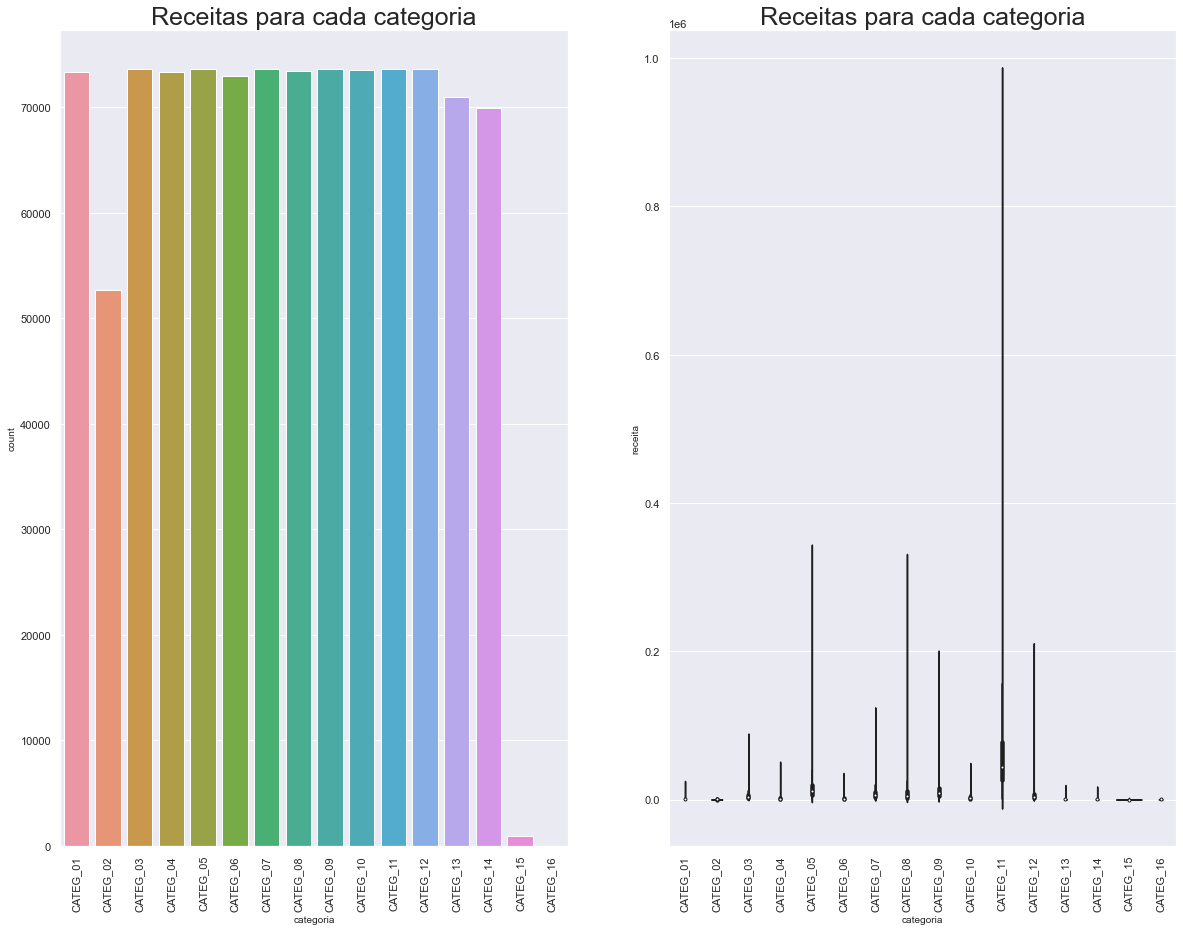

In [40]:
# plot 1
plt.subplot(1,2,1)
_ = sns.countplot(df3['categoria'])
_ = plt.title("Receitas para cada categoria", fontsize = 25)
_ = plt.xticks(rotation = 90)

# plot 2
plt.subplot(1,2,2)
_ = sns.violinplot(data = df3, x = 'categoria', y = 'receita', palette = 'dark')
_ = plt.title("Receitas para cada categoria", fontsize = 25)
_ = plt.xticks(rotation = 90)

### H5. Quanto mais produtos são vendidos, maior a receita

**Verdadeiro**. Pelo gráfico abaixo, verifica-se uma tendência praticamente linear de quantidade em relação a receita, sendo que ao longo dos meses o coeficiente angular da reta é diferente. Esta alta correlação é evidenciada, também, pelo coeficiente de correlação de Pearson, sendo bastante próximo de 1.

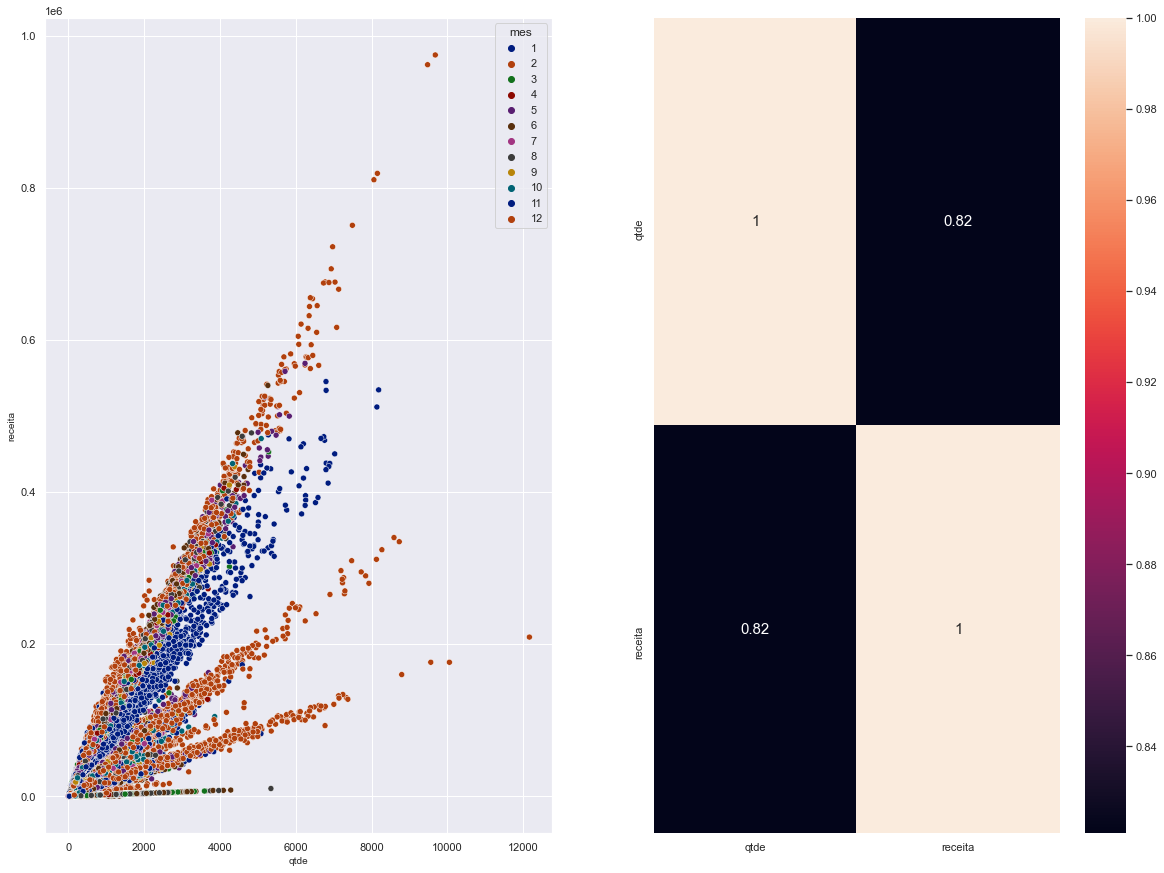

In [39]:
# plot 1
plt.subplot(1,2,1)
_ = sns.scatterplot(data = df3, x = 'qtde', y = 'receita', hue = 'mes', palette = 'dark')

# plot 2
plt.subplot(1,2,2)
_ = sns.heatmap(df3[['qtde', 'receita']].corr(method = 'pearson'), annot = True)

### 4.3. Análise Multivariada

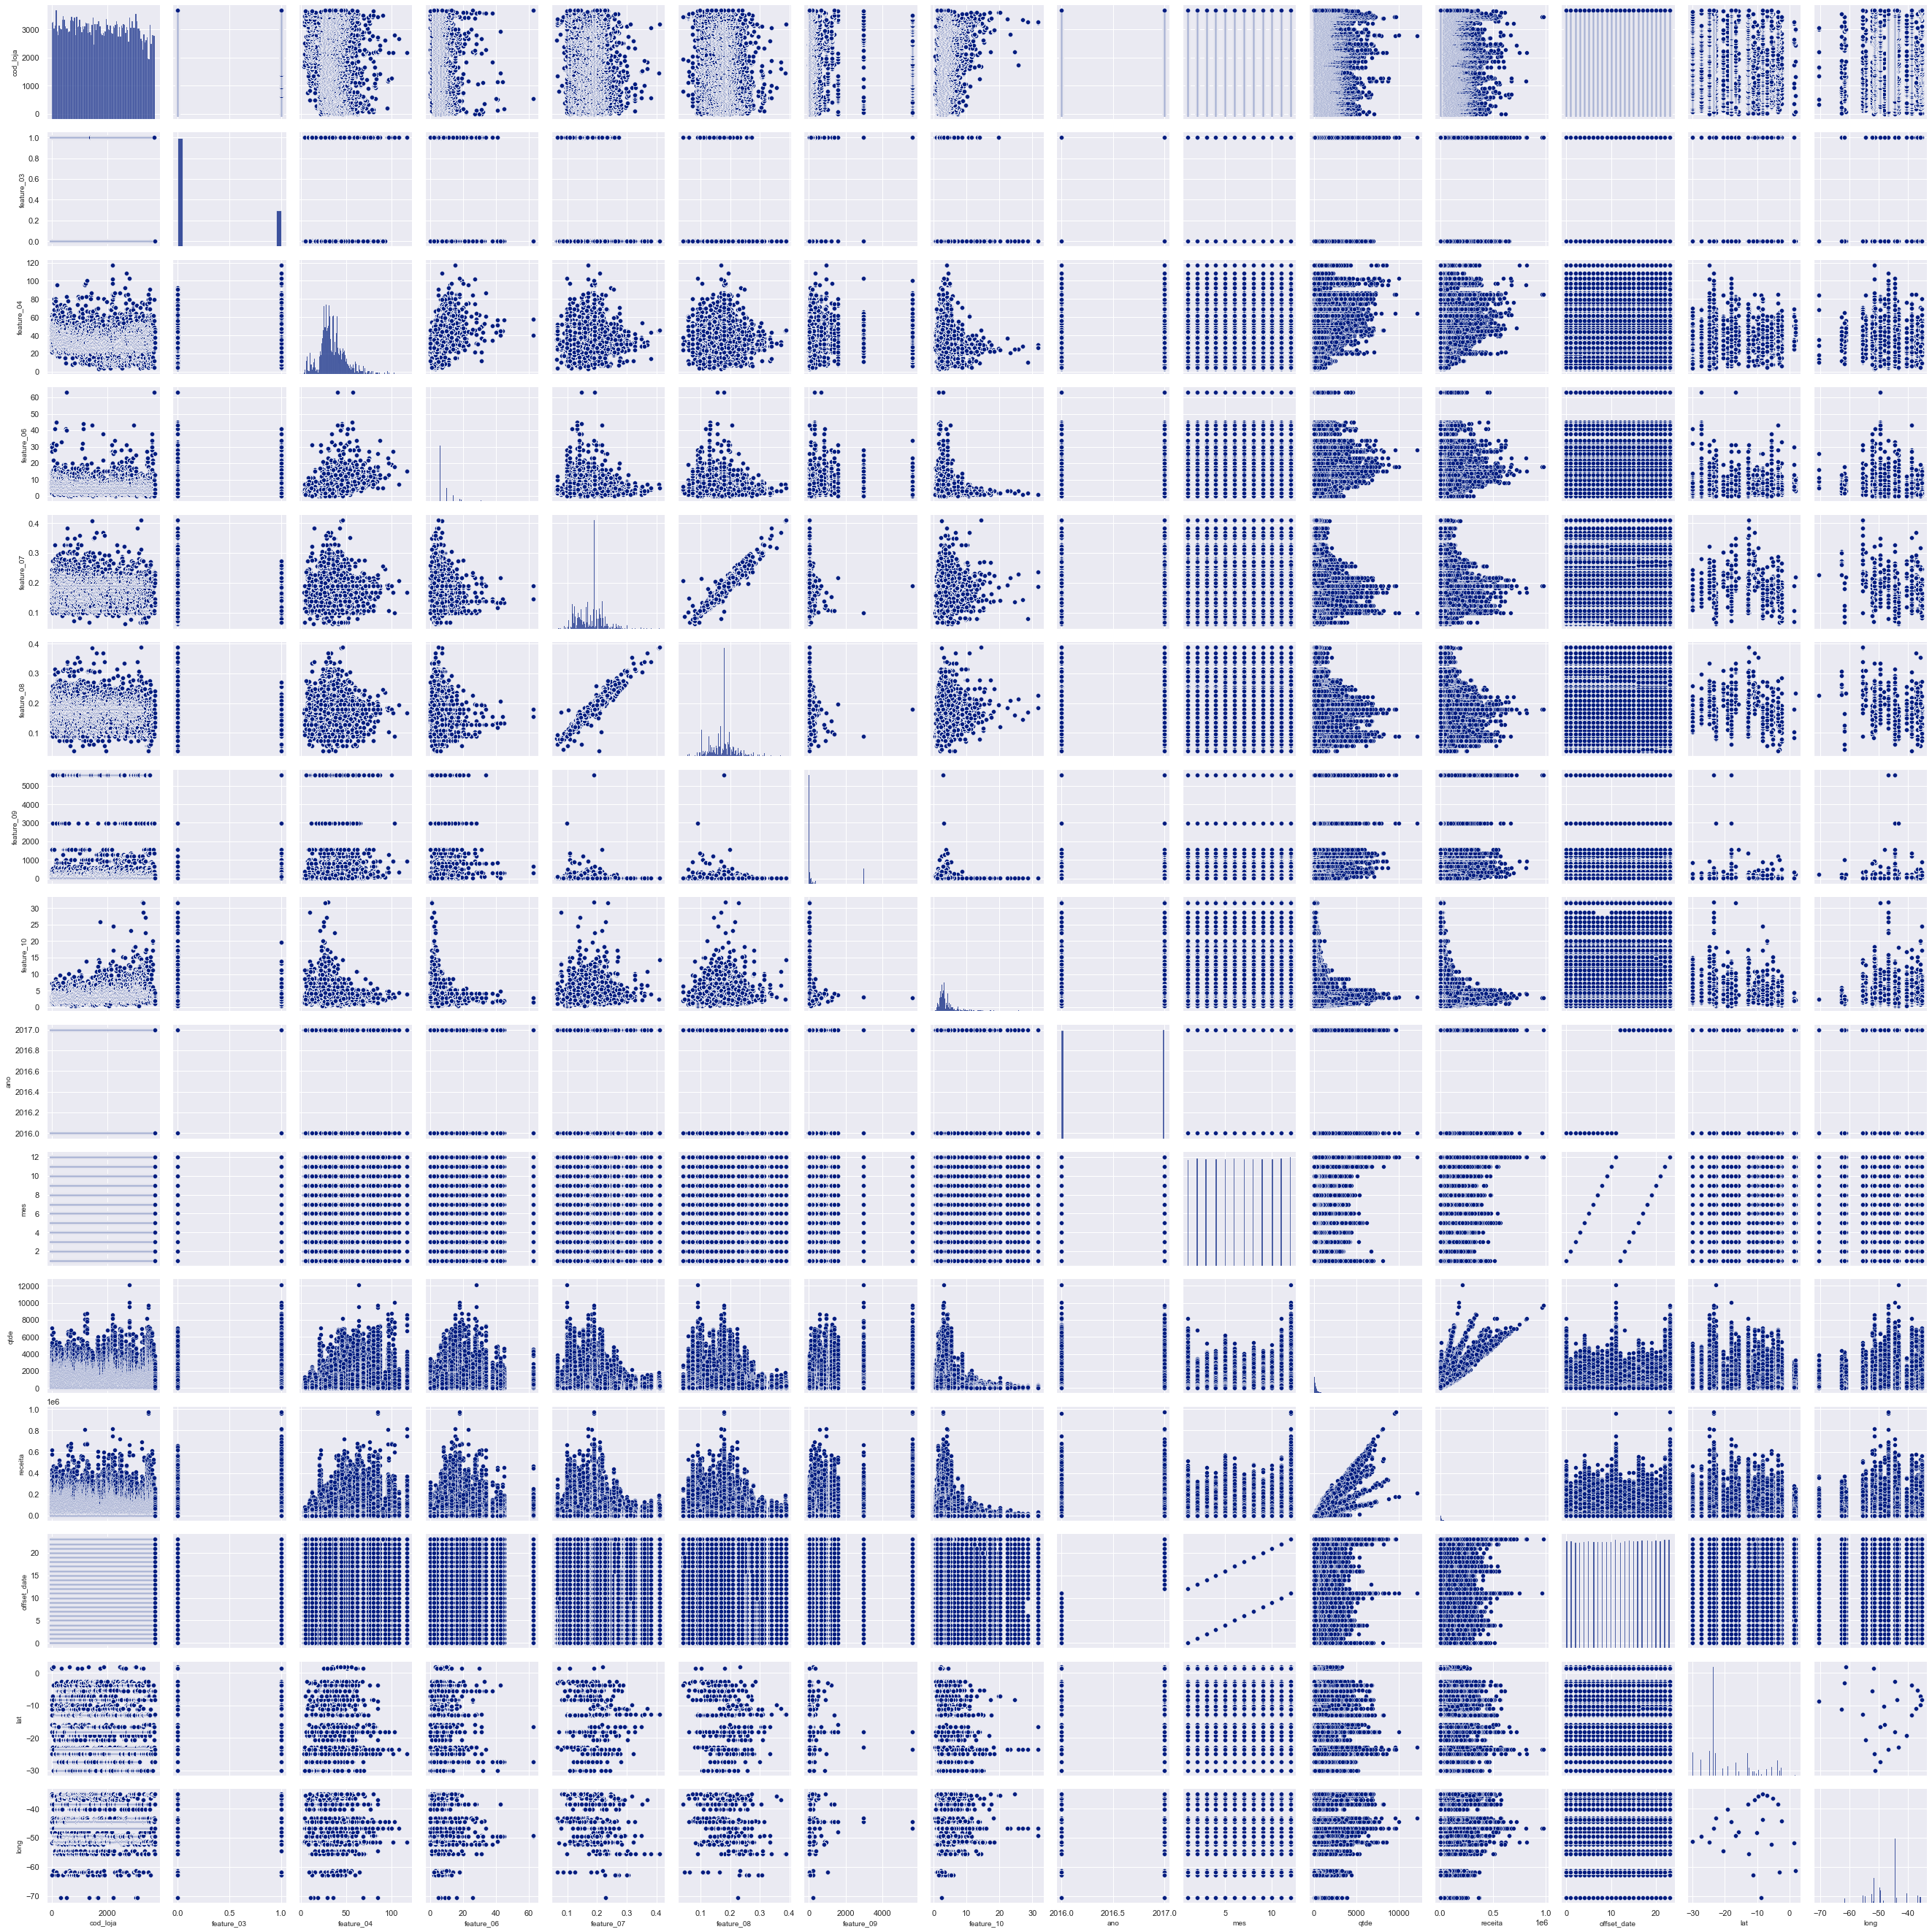

In [47]:
# pairplot
_ = sns.pairplot(df3)

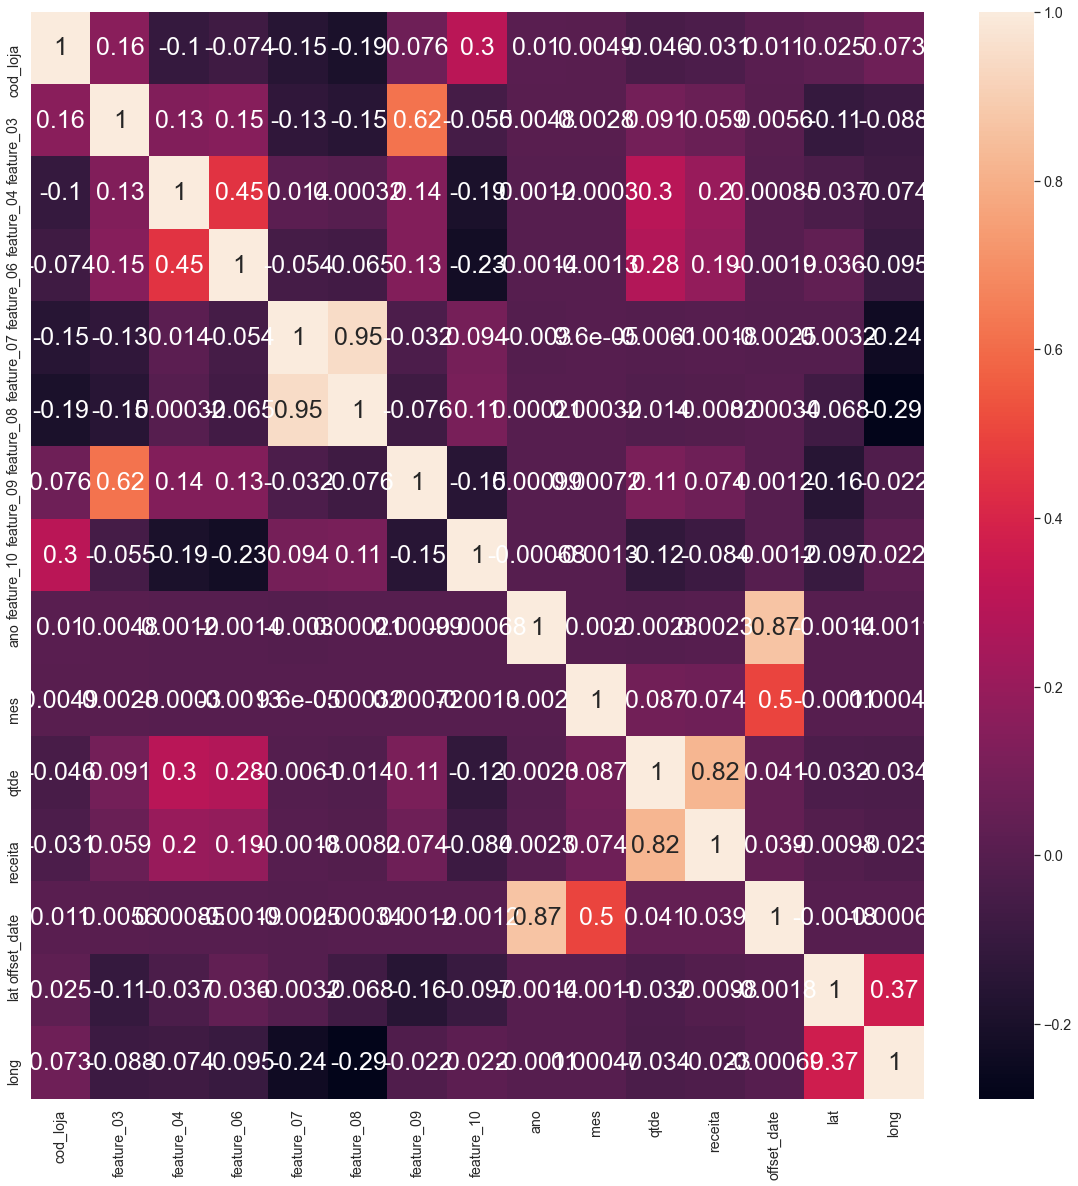

In [55]:
# retirando variaveis categoricas
aux = df3.select_dtypes(exclude = ['object'])

# plot correlação
f, ax = plt.subplots(figsize = (20, 20))
ax = sns.heatmap(aux.corr(method = 'pearson'), annot = True)